In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import date,timedelta
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns
import pandas_ta as ta
import numpy as np
import json
from tkinter import *
from tkinter import messagebox, ttk, END

/opt/anaconda3/envs/DataScience/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FONT_NAME = "Courier"
analysis = ['Price', 'Candlestick', 'RSI', 'MACD', 'Bollinger_Bands', 'M10_M20']

# Global variable to store the selected analysis
global_selected_analysis = []

# Functions
def send_data():
    global global_selected_analysis

    ticker = input_ticker.get().upper()
    days = input_time.get()
    mail = input_mail.get()
    name = input_name.get() 

    
    try:
        days = int(days)
    except ValueError:
        messagebox.showwarning(title="Warning", message="Days must be a number")
        return

    new_data = {
        "stock": {
            "ticker": ticker,
            "days": days,
            "mail": mail,
            "analysis": global_selected_analysis,
            "name": name
        }
    }

    # Validation checks
    if len(ticker) == 0 or days == 0 or len(mail) == 0:
        messagebox.showwarning(title="Warning", message="Check your data")
    elif len(ticker) >= 8:
        messagebox.showwarning(title="Warning", message='Ticker too long')
    elif days < 14 or days > 720:
        messagebox.showwarning(title="Warning", message='Check your date period, min 14 days max 720 days')
    elif "@" not in mail or "." not in mail or len(mail) < 6:
        messagebox.showwarning(title="Warning", message='Check your mail')
        return
    else:
        messagebox.showinfo(title="Check your mail", message='Data was sent, close the program or input next ticker.')

    # Save data to file
    try:
        data_file_path = './data/data.json'
        try:
            with open(data_file_path, mode="r") as data_file:
                data = json.load(data_file)
        except json.JSONDecodeError:
            data = {}

        data.update(new_data)

        with open(data_file_path, mode="w") as data_file:
            json.dump(data, data_file, indent=4)

    except Exception as e:
        messagebox.showerror(title="Error", message=f"An error occurred: {e}")
    finally:
        # Clear the input fields, but keep the mail for next mails, while program runs.
        input_ticker.delete(0, END)
        input_time.delete(0, END)
        input_name.delete(0, END)

# Function to get selected analysis
def selected_item():
    global global_selected_analysis  
    global_selected_analysis.clear()  
    chosen = listbox.curselection()  
    for v in chosen:
        op = listbox.get(v)
        global_selected_analysis.append(op)

    print(f"Inside selected_item: {global_selected_analysis}")

# UI
window = Tk()
window.config(padx=25, pady=25)
window.title('Stock Market Analysis')

# Load and display the stock graph image
canvas = Canvas(width=600, height=350, highlightthickness=0)
stock_png = PhotoImage(file='./images/stock_graph.png')
canvas.create_image(300, 150, image=stock_png)
canvas.grid(column=0, row=0, columnspan=3)

FONT_NAME = "Arial"

# Ticker Input
Label(text='Ticker Name:', font=(FONT_NAME, 12)).grid(column=0, row=1, sticky='e', padx=10, pady=5)
input_ticker = Entry(width=30)
input_ticker.grid(column=1, row=1, padx=10, pady=5)

# Stock/Company Full Name
Label(text='Company/Stock Full Name:', font=(FONT_NAME, 12)).grid(column=0, row=2, sticky='e', padx=10, pady=5)
input_name = Entry(width=30)
input_name.grid(column=1, row=2, padx=10, pady=5)

# Time Period Input
Label(text='Time Period (days, max 720):', font=(FONT_NAME, 12)).grid(column=0, row=3, sticky='e', padx=10, pady=5)
input_time = Entry(width=30)
input_time.grid(column=1, row=3, padx=10, pady=5)

# Email Input
Label(text='Your Email:', font=(FONT_NAME, 12)).grid(column=0, row=4, sticky='e', padx=10, pady=5)
input_mail = Entry(width=30)
input_mail.grid(column=1, row=4, padx=10, pady=5)

# Analysis Selection
Label(text='Choose Analysis Type:', font=(FONT_NAME, 12)).grid(column=0, row=5, sticky='e', padx=10, pady=5)
listbox = Listbox(window, selectmode='multiple', exportselection=0, width=30, height=5)
listbox.grid(column=1, row=5, padx=10, pady=5)

# Insert options into the listbox
for value in analysis:
    listbox.insert(END, value)

# Button to send data
button = Button(text='Send', command=lambda: [selected_item(), send_data()])  # First get selected item, then send data
button.grid(column=2, row=4)

window.mainloop()

Inside selected_item: []


2024-10-22 14:51:02.741 python[10630:98882] Warning: Expected min height of view: (<NSButton: 0x7f988ed2f200>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [3]:
data = pd.read_json('./data/data.json')
print(data)

                                                     stock
ticker                                             BTC-USD
days                                                   700
mail                              bartekszafran@icloud.com
analysis  [Price, Candlestick, RSI, MACD, Bollinger_Bands]
name                                               BITCOIN


In [4]:
ticker = data['stock']['ticker']
time = data['stock']['days']
name = data['stock']['name'].title()

In [5]:
today = date.today()
today = today.strftime('%Y-%m-%d')
start_date = date.today() - timedelta(days=time)
start_date = start_date.strftime('%Y-%m-%d')

In [6]:
ticker = ticker
stock_data = yf.download(ticker, start = start_date, end = today, progress=False)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-22,15782.300781,16253.047852,15656.606445,16189.769531,16189.769531,30726828760
2022-11-23,16195.588867,16638.193359,16170.502930,16610.707031,16610.707031,32958875628
2022-11-24,16611.636719,16771.474609,16501.767578,16604.464844,16604.464844,26129037414
2022-11-25,16602.269531,16603.316406,16388.404297,16521.841797,16521.841797,18678255976
2022-11-26,16521.576172,16666.863281,16416.228516,16464.281250,16464.281250,18000008764
...,...,...,...,...,...,...
2024-10-17,67617.078125,67912.210938,66647.390625,67399.835938,67399.835938,32790898511
2024-10-18,67419.109375,68969.750000,67177.820312,68418.789062,68418.789062,36857165014
2024-10-19,68418.976562,68668.007812,68024.640625,68362.734375,68362.734375,14443497908


In [7]:
#RSI, Garman, ATR, MACD
stock_data['RSI'] = ta.rsi(close = stock_data["Adj Close"], length=14)

stock_data['Garman'] = ((np.log(stock_data['High'])- np.log(stock_data['Low']))**2)/2-(2*np.log(2)-1)*((np.log(stock_data['Adj Close']) -np.log(stock_data['Open']))**2)

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
stock_data['ATR'] = compute_atr(stock_data)

def compute_macd(stock_data):
    macd = ta.macd(close=stock_data['Close'], length = 14).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
stock_data['MACD'] = compute_macd(stock_data)

today = date.today() 
two_weeks = today - timedelta(days=14)

#Last 14 days
technical_analysis = stock_data.iloc[-14:]
technical_analysis

,Open,High,Low,Close,Adj Close,Volume,RSI,Garman,ATR,MACD
Date,,,,,,,,,,
2024-10-08,62221.644531,63174.304688,61843.562500,62131.968750,62131.968750,28134475157,50.718012,0.000226,0.449790,-0.075157
2024-10-09,62131.726562,62508.835938,60314.613281,60582.101562,60582.101562,27670982363,44.458363,0.000392,0.470658,-0.219015
2024-10-10,60581.929688,61236.722656,58895.207031,60274.500000,60274.500000,30452813570,43.315717,0.000750,0.501286,-0.354049
2024-10-11,60275.460938,63400.871094,60046.125000,62445.089844,62445.089844,30327141594,52.577897,0.000995,0.607117,-0.317280
2024-10-12,62444.617188,63448.785156,62443.269531,63193.023438,63193.023438,16744110886,55.288934,0.000073,0.525954,-0.240101
2024-10-13,63192.945312,63272.652344,62035.636719,62851.375000,62851.375000,18177529690,53.776595,0.000184,0.468270,-0.203962
2024-10-14,62848.398438,66482.492188,62442.152344,66046.125000,66046.125000,43706958056,63.759325,0.001014,0.628825,0.032714
2024-10-15,66050.367188,67881.679688,64809.195312,67041.109375,67041.109375,48863870879,66.207128,0.000987,0.703986,0.278810
2024-10-16,67042.460938,68375.289062,66758.726562,67612.718750,67612.718750,38195189534,67.562611,0.000259,0.662576,0.501576


In [8]:
#Candlestick
fig = go.Figure(data=[go.Candlestick(x=stock_data.index, open = stock_data['Open'], close=stock_data['Close'], high = stock_data['High'], low=stock_data['Low'])])
fig.update_layout(xaxis_rangeslider_visible=False, yaxis_title=f'{ticker} stock', xaxis_title='Date', plot_bgcolor='lightgrey',
                  width=1050, height = 600)
fig.show()
#Save it to the folder
fig.write_image('./images/Candlestick.png')

In [9]:
#Price chart
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['Adj Close'], mode='lines', name='Adj Close')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Price',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/Price.png')


In [10]:
#RSI
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['RSI'], mode='lines', name='RSI')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} RSI',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/RSI.png')

In [11]:
#MACD
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['MACD'], mode='lines', name='MACD')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} MACD',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/MACD.png')

In [12]:
#MA
stock_data['M10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['M20'] = stock_data['Close'].rolling(window=20).mean()

#Bolinger Bands
stock_data['SD'] = stock_data['Close'].rolling(window=20).std()
# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
stock_data['UB'] = stock_data['M20'] + 2 * stock_data['SD']
stock_data['LB'] = stock_data['M20'] - 2 * stock_data['SD']

In [13]:
#BB
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['UB'], mode='lines', name='Upper Bollinger Band', visible=True, line=dict(color='red')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['M20'], mode='lines', name='Middle Bollinger Band', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Price (Bollinger)', visible=True, line=dict(color='black')))
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Bolinger Bands',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/Bollinger_Bands.png')

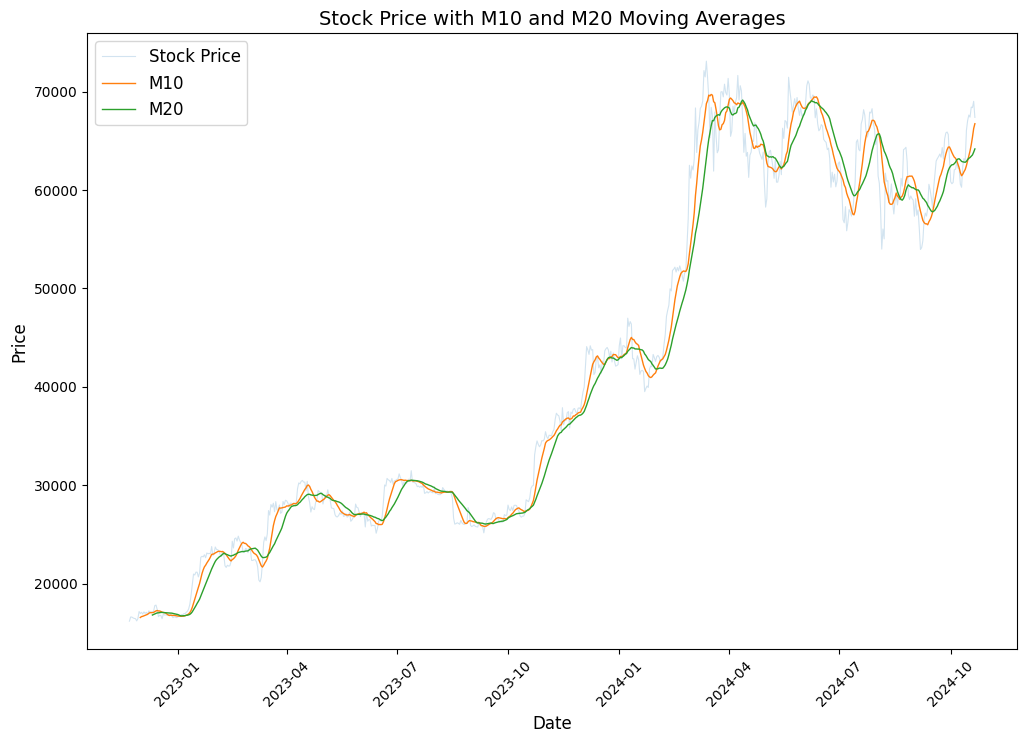

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(12,8))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', linewidth=0.8, alpha=0.2)

plt.plot(stock_data.index, stock_data['M10'], label='M10', linewidth=1, alpha=1)
plt.plot(stock_data.index, stock_data['M20'], label='M20', linewidth=1, alpha=1)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Stock Price with M10 and M20 Moving Averages', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()
plt.savefig('./images/M10_M20.png')

In [15]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()

NEWS_API = os.getenv('NEWS_API')
NEWS_ENDPOINT = os.getenv('NEWS_ENDPOINT')


news_params = {
    "apiKey": NEWS_API,
    "q": name,
    "sortBy" : "publishedAt",
    "language" : 'en'
    
}
news = requests.get(NEWS_ENDPOINT, params=news_params)
articles = news.json()['articles']
three_news = articles[:3]
three_news_formatted = '\n'.join(
    [f"Headline: {article['title']}\nText: {article['description']}\nLink: {article['url']}\n" for article in three_news])
print(three_news_formatted)

MissingSchema: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?

END ANALYSIS

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage

# Load environment variables, to keep private data safe
load_dotenv()

#Send mail to user
email = data['stock']['mail']

def send_analysis_email(global_selected_analysis):
    
    # Email setup
    mail = os.getenv('MAIL')
    password = os.getenv('PASSWORD')
    recipients = email  
    subject = 'Stock Analysis'
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587

    # Create the email message
    msg = MIMEMultipart()
    msg['From'] = mail
    msg['To'] = ', '.join(recipients)
    msg['Subject'] = subject

    body = f"""
    Analysis Report

    You have chosen the following technical analysis methods:
    - {'- '.join(global_selected_analysis)}

    Last open price: {stock_data['Open'][-1]}
    Last closed price: {stock_data['Close'][-1]}
    Volume: {stock_data['Volume'][-1]}

    Latest News:
    {three_news_formatted}
    """
    msg.attach(MIMEText(body, 'plain'))

    folder = './images/'

    # Attach the relevant images
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            analysis_type = filename[:-4]  # Remove the .png extension, so it can connect the analysis to graphs.
            if analysis_type in global_selected_analysis:
                file_path = os.path.join(folder, filename)
                if os.path.isfile(file_path):
                    try:
                        print(f"Attaching {file_path}")
                        with open(file_path, 'rb') as img_file:
                            img_data = img_file.read()
                            image = MIMEImage(img_data, name=filename)
                            msg.attach(image)
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

    # Send the email
    try:
        with smtplib.SMTP(smtp_server, smtp_port) as connection:
            connection.starttls()
            connection.login(user=mail, password=password)
            connection.sendmail(
                from_addr=mail,
                to_addrs=recipients,
                msg=msg.as_string()
            )
        print('Email with images was sent successfully!')
    except Exception as e:
        print(f"Error sending email: {e}")

send_analysis_email(global_selected_analysis)


Attaching ./images/Bollinger_Bands.png
Attaching ./images/Price.png
Attaching ./images/MACD.png
Attaching ./images/Candlestick.png
Attaching ./images/RSI.png


/var/folders/yk/fs7s5htj44b8ds6qh_c6gb0m0000gn/T/ipykernel_27092/2525724539.py:34: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/yk/fs7s5htj44b8ds6qh_c6gb0m0000gn/T/ipykernel_27092/2525724539.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/yk/fs7s5htj44b8ds6qh_c6gb0m0000gn/T/ipykernel_27092/2525724539.py:36: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Email with images was sent successfully!
